In [1]:
# My libraries that I use

import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy import ndimage,interpolate
from matplotlib.patches import Rectangle
from matplotlib import patheffects as pe

%matplotlib inline

In [2]:
# My functions for loading data, need the .npy and .json exported directly from Swift (select Raw NumPy option)

def LoadEELS_SI(fname):
    """
    Loads an EEL Spectrum Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: dat   - data (numpy array)
            cal   - pixel calibration in nm (float)
            disp  - energy dispersion in eV (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    disp=mdat['spatial_calibrations'][-1]['scale']
    return dat,cal,disp,mdat

def LoadImage(fname):
    """
    Loads a 2D STEM Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: im    - image data (numpy array)
            cal   - pixel calibration in nm (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    return dat,cal,mdat

In [ ]:
# Load HAADF data

filename='/path/to/haadf'
Z,Z_cal,Z_mdat=LoadImage('filename')

In [ ]:
# Function to add a clean scale bar to images

def AddScaleBar(axis,scale,cal,w=None,xy=None,units='nm',fontsize=10,text=True):
    """
    Adds scale bar to an image in a subplot
    Input:    axis     - subplot axis for added scalebar (matplotlib axis)
              scale    - desired length of scalebar in desired unit (int)
              cal      - calibration of image in desired units/pixel (float)
    Optional: w        - width of scale bar in pixels (float) Default: 1/50th of image height
              xy       - coordinates of top left corner of scale bar (tuple) NOTE: coordinates of bar not text
                          Default: None (puts bar w pixels in each dimension away from bottom left corner)
              units    - desired units (str) Default: 'nm'
              fontsize - size of font (float) Default: 8
              text     - Display actual text of scale bar (bool) Default: True
    Output: fig - displayed image (matplotlib figure)
    """   
    imdim=axis.get_images()[0].get_extent()
    dim=[int(imdim[2]-imdim[3]),int(imdim[1]-imdim[-0])]
    if not w: w=dim[0]/50.
    if not xy: xy=(w,dim[0]-2*w)
    axis.add_patch(Rectangle(xy,scale/cal,w,fc='w',ec='k',lw=0.5))
    if text: 
        txt=axis.text(xy[0]+0.5*scale/cal,xy[1],str(scale)+' '+units,fontweight='bold',color='w',fontsize=fontsize,ha='center',va='bottom')
        txt.set_path_effects([pe.withStroke(linewidth=1,foreground='k')])
    return

In [ ]:
# Display HAADF

scale=100
f,a=plt.subplots(1,1,dpi=100)
a.imshow(Z)
AddScaleBar(a,scale,Z_cal)

In [8]:
# Load Spectrum Image

filename='/Users/j6h/Analyses/Data/Unocic-ORNL/Kinga_Helium/STEM SI.npy'
dat,cal,disp,mdat=LoadEELS_SI(filename)

In [ ]:
# Generate calibrated energy axis (Assumes no ZLP and data already calibrated)

off=mdat['spatial_calibrations'][2]['offset']
E=np.arange(dat.shape[2])*disp+off

In [23]:
# Functions to facilitate easy analysis

def NormArray(arr):
    """
    Converts an array of arbitrary values to a 0-1 range
    
    Input:  arr  - numpy array
    Output: narr - normalized numpy array
    """    
    
    arr = np.asarray(arr)
    M=np.amax(arr);m=np.amin(arr)
    narr = (arr-m)/(M-m)
    return narr

def Get_i(arr,val):
    """
    Gives index of array closest to desired value
    
    Input:  arr - numpy array
            val - float
    Output: i   - index of closest value to desired float (int)
    """    
    
    i=np.argmin(np.abs(arr-val))
    return i

def Get_FWHM(en,spec,interp=False):
    """
    Finds FWHM of ZLP and returns half-maxes and width in energy
    
    Input:  en    - energy loss axis (numpy array)
            spec  - EELS axis (numpy array)
    Output: en_lo - energy of lower half max in eV (float)
            en_hi - energy of upper half max in eV (float)
            en_w  - FWHM of ZLP in eV (float)
    """    
    
    s=NormArray(spec)
    i_lo=Get_i(s[:np.argmax(s)],0.5)
    i_hi=Get_i(s[np.argmax(s):],0.5)+np.argmax(s)
    if interp:
        #disp=en[1]-en[0];disp_i=disp/100.
        #en_lo_fit=np.arange(en[i_lo-1:i_lo+1],disp_i);en_hi_fit=np.arange(en[i_hi-1:i_hi+1],disp_i)
        f_lo=interpolate.interp1d(s[i_lo-1:i_lo+2],en[i_lo-1:i_lo+2])
        f_hi=interpolate.interp1d(s[i_hi-1:i_hi+2],en[i_hi-1:i_hi+2])
        print(i_lo,i_hi)
        en_lo=f_lo(0.5);en_hi=f_hi(0.5)
    else: en_lo=en[i_lo];en_hi=en[i_hi]
    en_w=en_hi-en_lo
    return en_lo,en_hi,en_w

def FitPowerlaw(E,S,fen_lo,fen_hi,visualize=True):
    """
    Fits a power law background to an EEL spectrum over an energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              fen_lo   - lower energy limit (float)
              fen_hi   - upper energy limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo=Get_i(E,fen_lo);i_hi=Get_i(E,fen_hi)
    elog=np.log(E[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    slog=np.log(S[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[i_lo:]
    BG_out=np.exp(A0)*E[i_lo:]**(r)
    S_out=S[i_lo:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo:i_hi],NormArray(S)[i_lo:i_hi],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

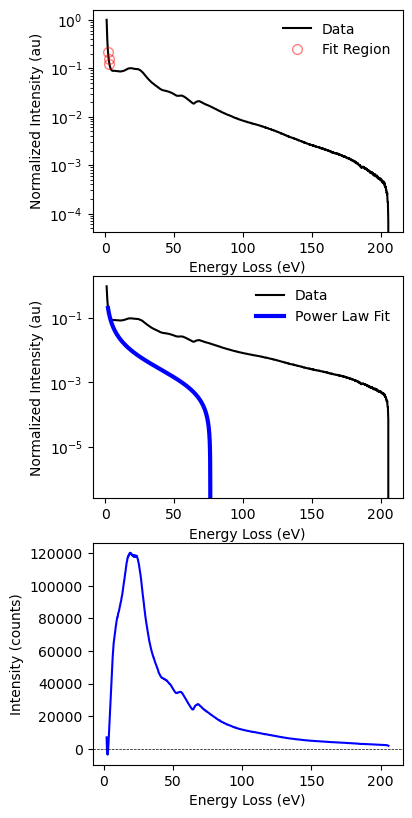

In [27]:
test=FitPowerlaw(E,np.average(dat,axis=(0,1)),2,3.5)

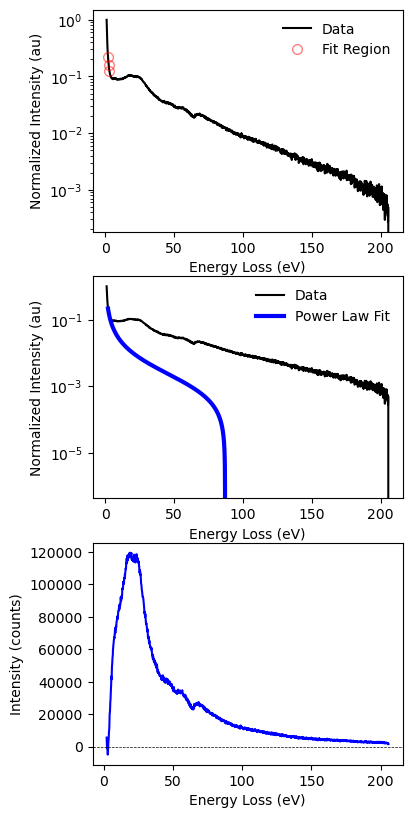

In [29]:
test=FitPowerlaw(E,dat[10,15],2,3.5)

In [30]:
def FitPowerlaw_SI(E,SI,fen_lo,fen_hi):
    """
    Fits a power law background to every spectrum in EEL SI 
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              SI       - 3D Spectrum Image (numpy array)
              fen_lo - lower energy range lower limit (float)
              fen_hi - lower energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo=Get_i(E,fen_lo);i_hi=Get_i(E,fen_hi)
    E_Fit=E[i_lo:i_hi]
    E_out=E[i_lo:]
    SI_out=[];BG_out=[]
    for Row in SI:
        SI_out.append([]);BG_out.append([])
        for Spec in Row:
            Spec_Fit=Spec[i_lo:i_hi]
            elog=np.log(E_Fit[np.where(Spec_Fit>0)])
            slog=np.log(Spec_Fit[np.where(Spec_Fit>0)])
            r,A0=np.polyfit(elog,slog,1)
            BG_out[-1].append(np.exp(A0)*E_out**(r))
            SI_out[-1].append(Spec[i_lo:]-np.exp(A0)*E_out**(r))     
    return E_out,np.asarray(BG_out),np.asarray(SI_out)

In [31]:
E_f,BG_f,SI_f=FitPowerlaw_SI(E,dat,2,3.5)

(0.0, 75.0)

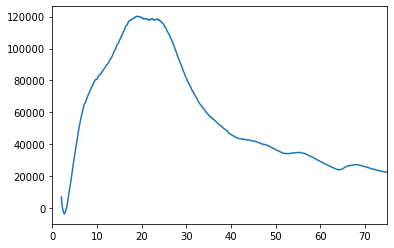

In [36]:
fig=plt.figure()
plt.plot(E_f,np.average(SI_f,axis=(0,1)))
plt.xlim(0,75)
# plt.ylim(0,0.2e6)


In [38]:
### Create new color maps

Purple=150./255,50/255., 1.
Orange=1,120./255, 0
Blue=10./255,175/255., 1.
Red=200./255,20/255., 20/225.
Green=30./255,200./255, 30./255
Yellow=220./255,220./255, 90./255
Pink=255/255.,105/255., 180/255.
Gold=155/255.,205/255.,32/255.
Turquoise=72/255., 229/255., 204/255.
Brown=220/255., 142/255., 105/255.
Forest=64/255., 169/255., 64/255.
Gray=159/255., 176/255., 184/255.
Royal=95/255., 55/255., 255/255.

colors=[Blue,Red,Green,Purple,Orange,Yellow,Pink,Gray,Royal,Turquoise,Gold,Forest,Brown]

from matplotlib.colors import LinearSegmentedColormap
bBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Blue   ,(1,1,1)], N=100)
bRw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Red    ,(1,1,1)], N=100)
bGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Green  ,(1,1,1)], N=100)
bPw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Purple ,(1,1,1)], N=100)
bOw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Orange ,(1,1,1)], N=100)
bYw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Yellow ,(1,1,1)], N=100)
bPiw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Pink ,(1,1,1)], N=100)
bGrw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Gray ,(1,1,1)], N=100)
bRow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Royal ,(1,1,1)], N=100)
bGow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Gold ,(1,1,1)], N=100)
bTuw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Turquoise ,(1,1,1)], N=100)
bBrw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Brown ,(1,1,1)], N=100)
bFow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Forest ,(1,1,1)], N=100)


colormaps=[bBw,bRw,bGw,bPw,bOw,bYw,bPiw,bGrw,bRow,bTuw,bGow,bBrw,bFow]


/Users/j6h/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


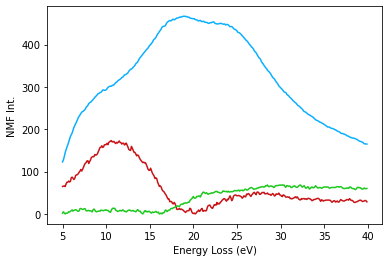

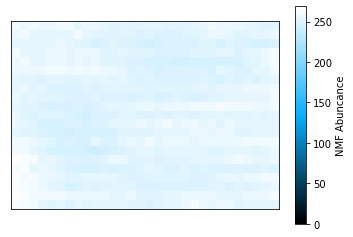

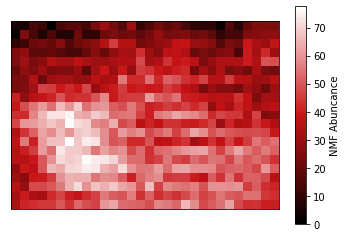

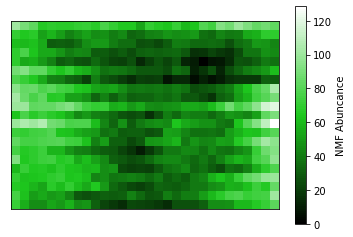

In [41]:
use_E=E_f
use_SI=SI_f[3:]
Ecut_l=5
Ecut_h=40
i_l=Get_i(use_E,Ecut_l)
i_h=Get_i(use_E,Ecut_h)
Enmf=use_E[i_l:i_h]
SInmf=use_SI[:,:,i_l:i_h]
d=SInmf.shape
from sklearn.decomposition import NMF

NMFdat=np.copy(SInmf.reshape((np.prod(d[:2]),d[2])))
NMFdat[np.where(NMFdat<0)]=0
N=3
model=NMF(n_components=N,max_iter=10000)
NMFIm=model.fit_transform(NMFdat)
NMFSpec=model.components_
NMFIm=NMFIm.reshape(d[:2]+(N,)).transpose(2,0,1)

for i in range(N): plt.plot(Enmf,NMFSpec[i],c=colors[i])
plt.xlabel('Energy Loss (eV)')
plt.ylabel('NMF Int.')
plt.show()
for i in range(N): 
    f,a=plt.subplots(1,1)
    plt.setp(a,xticks=[],yticks=[])
    cb=a.imshow(NMFIm[i],cmap=colormaps[i],vmin=0)
    plt.colorbar(cb,ax=a,label='NMF Abuncance')
    plt.show()

E_NMF_3=Enmf
SIn_3_NMFSpec=np.copy(NMFSpec)
SIn_3_NMFIm=np.copy(NMFIm)